In [456]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [464]:
df=pd.read_excel('Dataset_FINAL2.xlsx', delimiter=';',header = 0)
df_all =df
df_all2 =df
df_all2['Camas'] =df['Camas Funcionantes']
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1096, 8)


date  Estancias  Camas Funcionantes  \
0 2016-04-06        846                1260   
1 2016-04-07        889                1257   
2 2016-04-08        747                1249   
3 2016-04-09        765                1249   
4 2016-04-10        874                1248   

   Intervenciones Quirúrgicas Hospitalizadas  Urgencias hospitalizados  \
0                                     5.0000                   57.0000   
1                                    67.0000                   78.0000   
2                                    40.0000                   55.0000   
3                                     8.0000                   49.0000   
4                                    80.0000                   70.0000   

   date_pred  Ocupacion  Camas  
0 2019-04-07    67.1429   1260  
1 2019-04-08    70.7239   1257  
2 2019-04-09    59.8078   1249  
3 2019-04-10    61.2490   1249  
4 2019-04-11    70.0321   1248

Approx 1.2% of value in Ocupacion column are missing, it is not a big deal, I decided to remove them.

In [465]:
df_all.columns

Index(['date', 'Estancias', 'Camas Funcionantes',
       'Intervenciones Quirúrgicas Hospitalizadas', 'Urgencias hospitalizados',
       'date_pred', 'Ocupacion', 'Camas'],
      dtype='object')

In [466]:
df.columns
df['date_time'] = df['date']
df['date_time']

0      2016-04-06
1      2016-04-07
2      2016-04-08
3      2016-04-09
4      2016-04-10
          ...    
1091   2019-04-02
1092   2019-04-03
1093   2019-04-04
1094   2019-04-05
1095   2019-04-06
Name: date_time, Length: 1096, dtype: datetime64[ns]

In [467]:


df['Ocupacion'] = pd.to_numeric(df['Ocupacion'], errors='coerce')
df = df.dropna(subset=['Ocupacion'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Ocupacion', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.tail(5)

(1096, 7)
2016-04-06 00:00:00
2019-04-06 00:00:00


date_time  Ocupacion  year  quarter  month  day  weekday
1091 2019-04-02    80.9647  2019        2      4    2        1
1092 2019-04-03    83.6596  2019        2      4    3        1
1093 2019-04-04    78.9203  2019        2      4    4        1
1094 2019-04-05    85.7509  2019        2      4    5        1
1095 2019-04-06    84.8667  2019        2      4    6        0

In [468]:

df_all['Estancias'] = pd.to_numeric(df_all['Estancias'], errors='coerce')
df_all = df_all.dropna(subset=['Estancias'])
df_all['date_time']=pd.to_datetime(df_all['date_time']) 
df_all['year'] = df_all['date_time'].apply(lambda x: x.year)
df_all['quarter'] = df_all['date_time'].apply(lambda x: x.quarter)
df_all['month'] = df_all['date_time'].apply(lambda x: x.month)
df_all['day'] = df_all['date_time'].apply(lambda x: x.day)
df_all=df_all.loc[:,['date_time','Estancias', 'year','quarter','month','day']]
df_all.sort_values('date_time', inplace=True, ascending=True)
df_all = df_all.reset_index(drop=True)
df_all["weekday"]=df_all.apply(lambda row: row["date_time"].weekday(),axis=1)
df_all["weekday"] = (df_all["weekday"] < 5).astype(int)
print(df_all.shape)
print(df_all.date_time.min())
print(df_all.date_time.max())
df_all.tail(5)

(1096, 7)
2016-04-06 00:00:00
2019-04-06 00:00:00


date_time  Estancias  year  quarter  month  day  weekday
1091 2019-04-02        940  2019        2      4    2        1
1092 2019-04-03        983  2019        2      4    3        1
1093 2019-04-04        921  2019        2      4    4        1
1094 2019-04-05       1005  2019        2      4    5        1
1095 2019-04-06        987  2019        2      4    6        0

In [469]:

df_all2['Camas'] = pd.to_numeric(df_all2['Camas'], errors='coerce')
df_all2 = df_all2.dropna(subset=['Camas'])
df_all2['date_time']=pd.to_datetime(df_all2['date_time']) 
df_all2['year'] = df_all2['date_time'].apply(lambda x: x.year)
df_all2['quarter'] = df_all2['date_time'].apply(lambda x: x.quarter)
df_all2['month'] = df_all2['date_time'].apply(lambda x: x.month)
df_all2['day'] = df_all2['date_time'].apply(lambda x: x.day)
df_all2=df_all2.loc[:,['date_time','Camas', 'year','quarter','month','day']]
df_all2.sort_values('date_time', inplace=True, ascending=True)
df_all2 = df_all2.reset_index(drop=True)
df_all2["weekday"]=df_all2.apply(lambda row: row["date_time"].weekday(),axis=1)
df_all2["weekday"] = (df_all2["weekday"] < 5).astype(int)
print(df_all2.shape)
print(df_all2.date_time.min())
print(df_all2.date_time.max())
df_all2.tail(5)

(1096, 7)
2016-04-06 00:00:00
2019-04-06 00:00:00


date_time  Camas  year  quarter  month  day  weekday
1091 2019-04-02   1161  2019        2      4    2        1
1092 2019-04-03   1175  2019        2      4    3        1
1093 2019-04-04   1167  2019        2      4    4        1
1094 2019-04-05   1172  2019        2      4    5        1
1095 2019-04-06   1163  2019        2      4    6        0

In [470]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (1096, 7)
The time series starts from:  2016-04-06 00:00:00
The time series ends on:  2019-04-06 00:00:00


### Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

In [471]:
stat, p = stats.normaltest(df.Ocupacion)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=138.445, p=0.000
Data does not look Gaussian (reject H0)


We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

Kurtosis of normal distribution: 2.677788071723942
Skewness of normal distribution: 0.6433531772413615


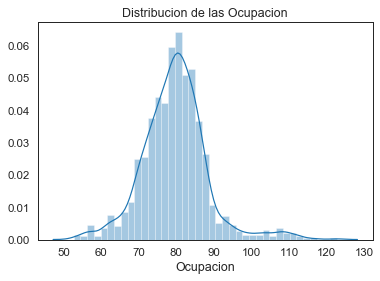

In [472]:
# print(df.Ocupacion.describe())
ax =sns.distplot(df.Ocupacion);
ax.set_title('Distribucion de las Ocupacion')
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Ocupacion)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Ocupacion)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0.  If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero. 

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

### First Time series plot

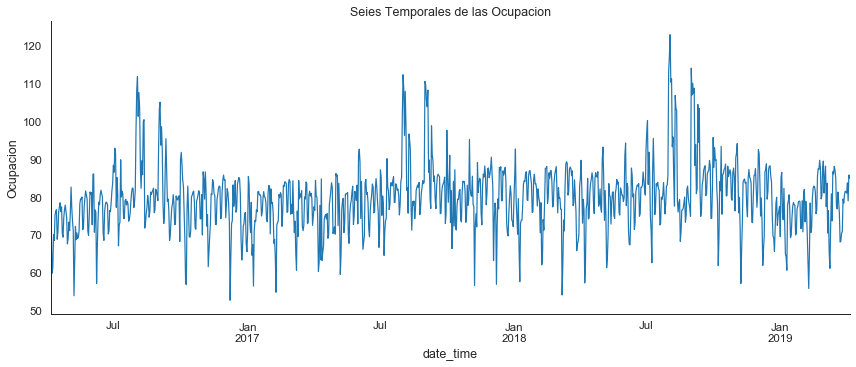

In [473]:
df1=df.loc[:,['date_time','Ocupacion']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Ocupacion')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Seies Temporales de las Ocupacion')
sns.despine(top=True)
plt.show();

Apparently, this plot is not a good idea. Don't do this.

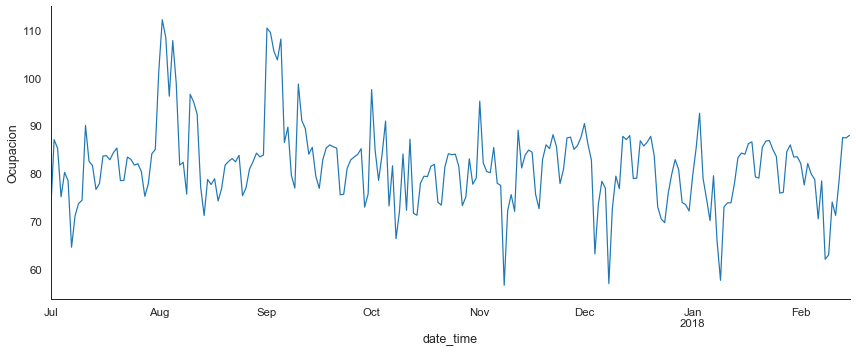

In [444]:
df2=df1[(df1.index>='2017-07-01') & (df1.index<'2018-02-16')]
df2.plot(figsize=(12,5));
plt.ylabel('Ocupacion')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

### Box plot of yearly vs. quarterly Ocupacion

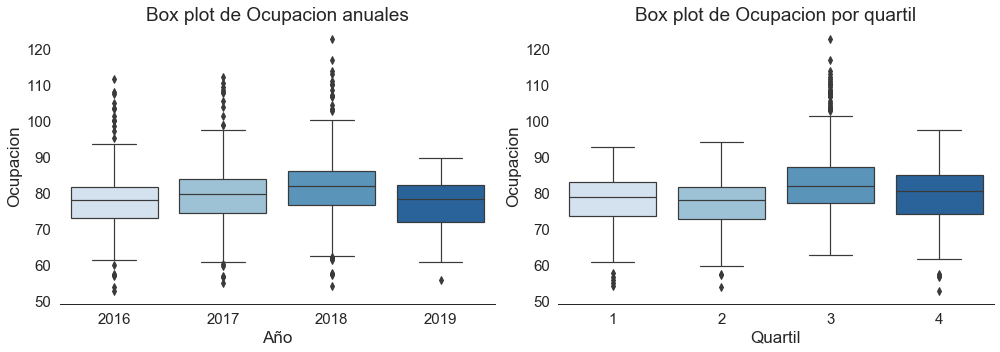

In [445]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=6.9)

b =sns.boxplot(x="year", y="Ocupacion", data=df,palette="Blues")
b.tick_params(labelsize=15)
plt.ylabel('Ocupacion',fontsize=17)

plt.xlabel('Año', fontsize=17)
plt.title('Box plot de Ocupacion anuales',fontsize=19)
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
b=sns.boxplot(x="quarter", y="Ocupacion", data=df,palette="Blues")

b.tick_params(labelsize=15)
plt.ylabel('Ocupacion',fontsize=17)
plt.xlabel('Quartil',fontsize=17)
plt.title('Box plot de Ocupacion por quartil',fontsize=19)
sns.despine(left=True)
plt.tight_layout();

### Ocupacion Distribution

count      mean    std       min       25%       50%       75%  \
Ocupacion 1096.0000   79.6466 8.7217   52.6936   74.5724   79.6797   84.0005   
year      1096.0000 2017.2619 0.9284 2016.0000 2017.0000 2017.0000 2018.0000   
quarter   1096.0000    2.5091 1.1169    1.0000    2.0000    3.0000    4.0000   
month     1096.0000    6.5237 3.4487    1.0000    4.0000    7.0000   10.0000   
day       1096.0000   15.7117 8.8011    1.0000    8.0000   16.0000   23.0000   
weekday   1096.0000    0.7144 0.4519    0.0000    0.0000    1.0000    1.0000   

                max  
Ocupacion  122.7545  
year      2019.0000  
quarter      4.0000  
month       12.0000  
day         31.0000  
weekday      1.0000

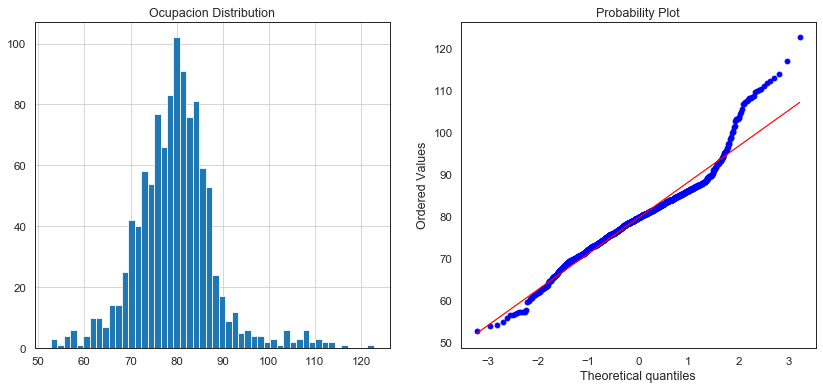

In [446]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Ocupacion'].hist(bins=50)
plt.title('Ocupacion Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Ocupacion'], plot=plt);
df.describe().T

Normal probability plot also shows the data set is far from normally distributed.

### Average Ocupacion resampled over day, week, month, quarter and year.

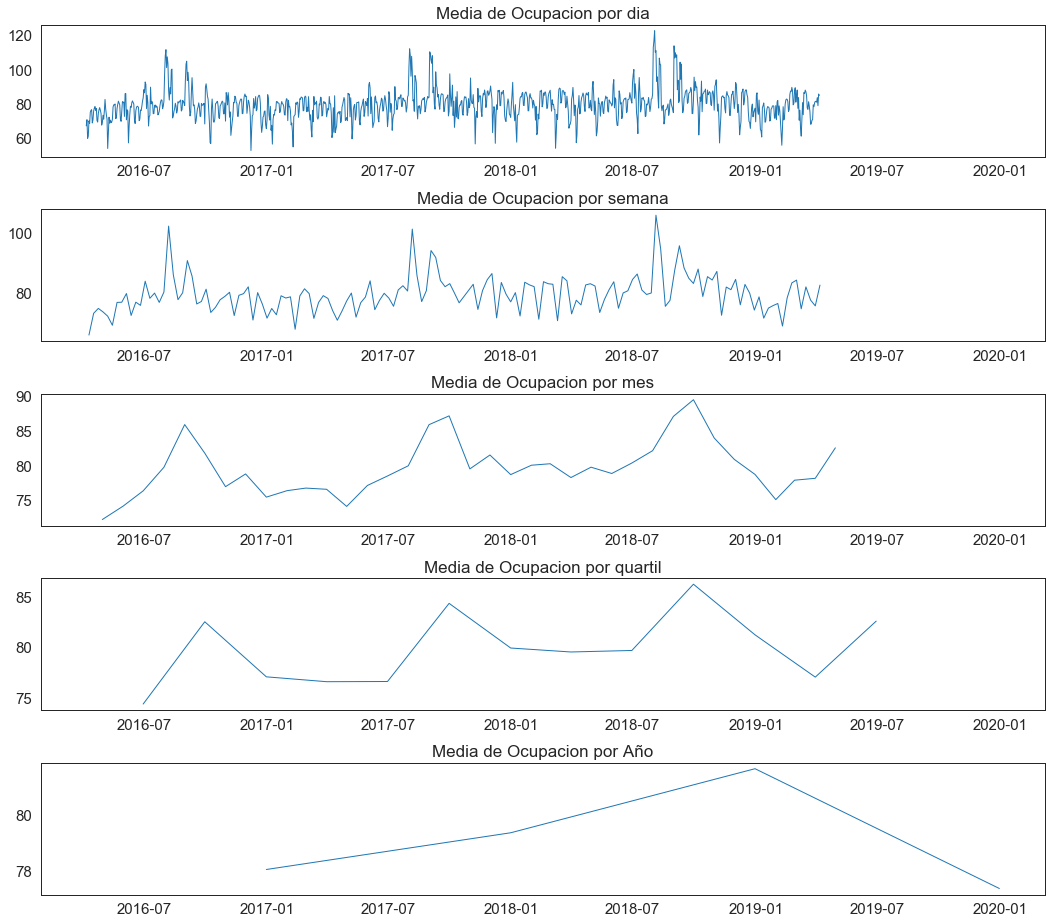

In [447]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Ocupacion'].resample('D').mean(),linewidth=1)
ax1.set_title('Media de Ocupacion por dia',fontsize=17)
ax1.tick_params(axis='both', which='major',labelsize=15)

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Ocupacion'].resample('W').mean(),linewidth=1)
ax2.set_title('Media de Ocupacion por semana',fontsize=17)
ax2.tick_params(axis='both', which='major',labelsize=15)

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Ocupacion'].resample('M').mean(),linewidth=1)
ax3.set_title('Media de Ocupacion por mes',fontsize=17)
ax3.tick_params(axis='both', which='major',labelsize=15)

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Ocupacion'].resample('Q').mean(),linewidth=1)
ax4.set_title('Media de Ocupacion por quartil',fontsize=17)
ax4.tick_params(axis='both', which='major',labelsize=15)

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Ocupacion'].resample('A').mean(),linewidth=1)
ax5.set_title('Media de Ocupacion por Año',fontsize=17)
ax5.tick_params(axis='both', which='major',labelsize=15);

In general, our time series does not have a general upward or downward trend. The highest average ocupacion was prior to 2007, it decreased significantly in one year until early 2018, and has been steady since then.

In [448]:
df.Ocupacion

0      67.1429
1      70.7239
2      59.8078
3      61.2490
4      70.0321
         ...  
1091   80.9647
1092   83.6596
1093   78.9203
1094   85.7509
1095   84.8667
Name: Ocupacion, Length: 1096, dtype: float64

### Plot mean Ocupacion grouped by year, quarter, month and day.

In [429]:
df.columns

Index(['date_time', 'Ocupacion', 'year', 'quarter', 'month', 'day', 'weekday'], dtype='object')

Text(0.5, 0, '')

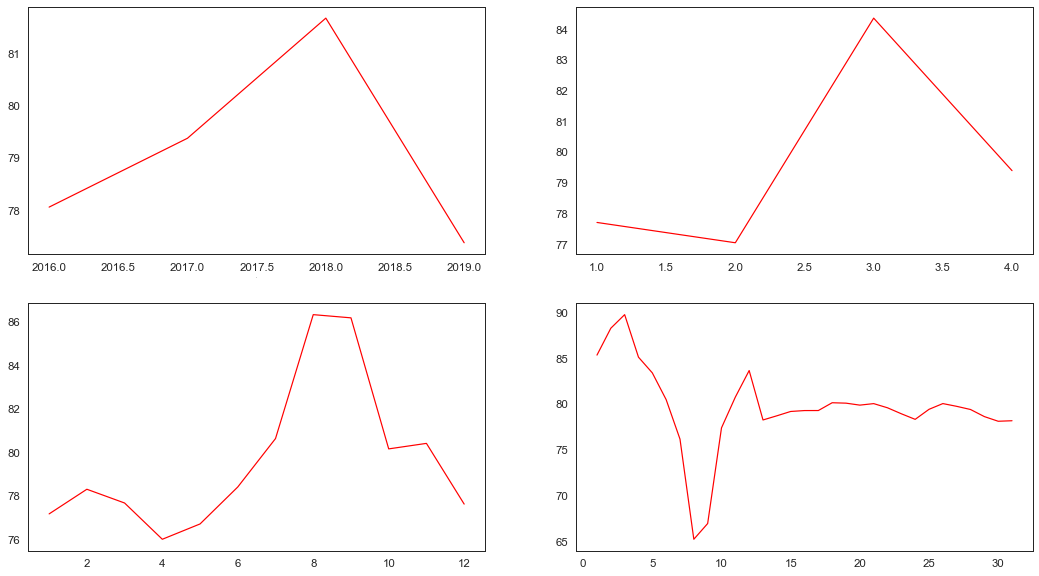

In [496]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
df.groupby('year').Ocupacion.agg('mean').plot(color='red')
plt.xlabel('',fontsize=19)
#plt.title('Media de Ocupacion por Año',fontsize=19)

plt.subplot(2,2,2)
df.groupby('quarter').Ocupacion.agg('mean').plot(color='red')
plt.xlabel('',fontsize=19)
#plt.title('Media de Ocupacion por Quartil',fontsize=19)

plt.subplot(2,2,3)
df.groupby('month').Ocupacion.agg('mean').plot(color='red')
plt.xlabel('',fontsize=19)
#plt.title('Media de Ocupacion por Mes',fontsize=19)

plt.subplot(2,2,4)
df.groupby('day').Ocupacion.agg('mean').plot(color='red')
plt.xlabel('',fontsize=19)
#plt.title('Media de Ocupacion por Día',fontsize=19);

''

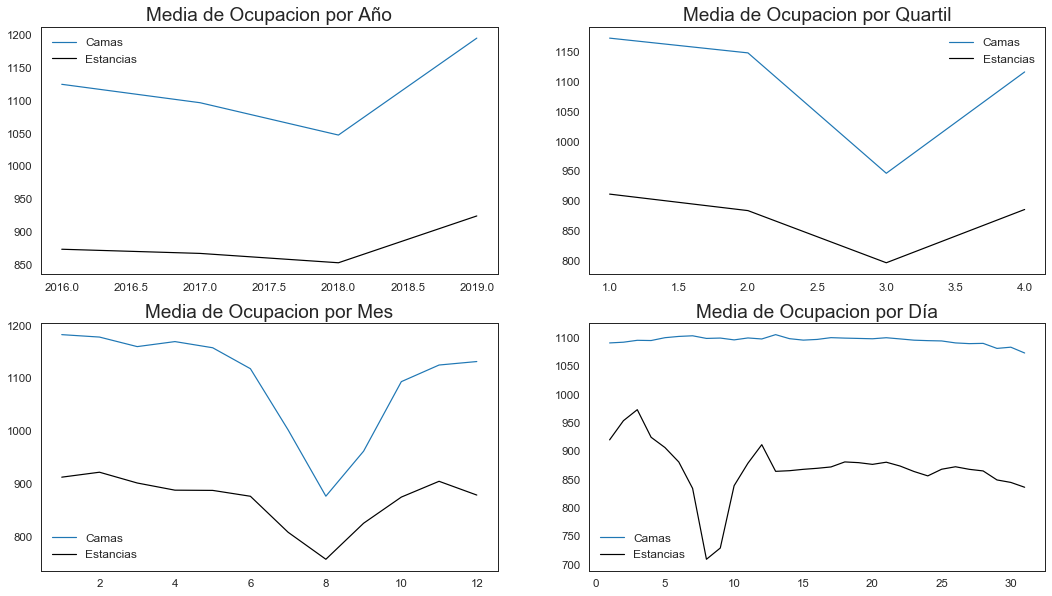

In [501]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
df_all2.groupby('year').Camas.agg('mean').plot()
df_all.groupby('year').Estancias.agg('mean').plot(color='black')
plt.xlabel('',fontsize=19)
plt.title('Media de Ocupacion por Año',fontsize=19)
plt.legend(fontsize=12,loc='upper ', frameon=False)

plt.subplot(2,2,2)
df_all2.groupby('quarter').Camas.agg('mean').plot()
df_all.groupby('quarter').Estancias.agg('mean').plot(color='black')

plt.xlabel('',fontsize=19)
plt.title('Media de Ocupacion por Quartil',fontsize=19)
plt.legend(fontsize=12,loc='upper lft', frameon=False)
plt.subplot(2,2,3)
df_all2.groupby('month').Camas.agg('mean').plot()
df_all.groupby('month').Estancias.agg('mean').plot(color='black')

plt.xlabel('',fontsize=19)
plt.title('Media de Ocupacion por Mes',fontsize=19)
plt.legend(fontsize=12,loc='upper ', frameon=False)
plt.subplot(2,2,4)
df_all2.groupby('day').Camas.agg('mean').plot()
df_all.groupby('day').Estancias.agg('mean').plot(color='black')

plt.xlabel('',fontsize=19)
plt.title('Media de Ocupacion por Día',fontsize=19)
plt.legend(fontsize=12, frameon=False)
;

''

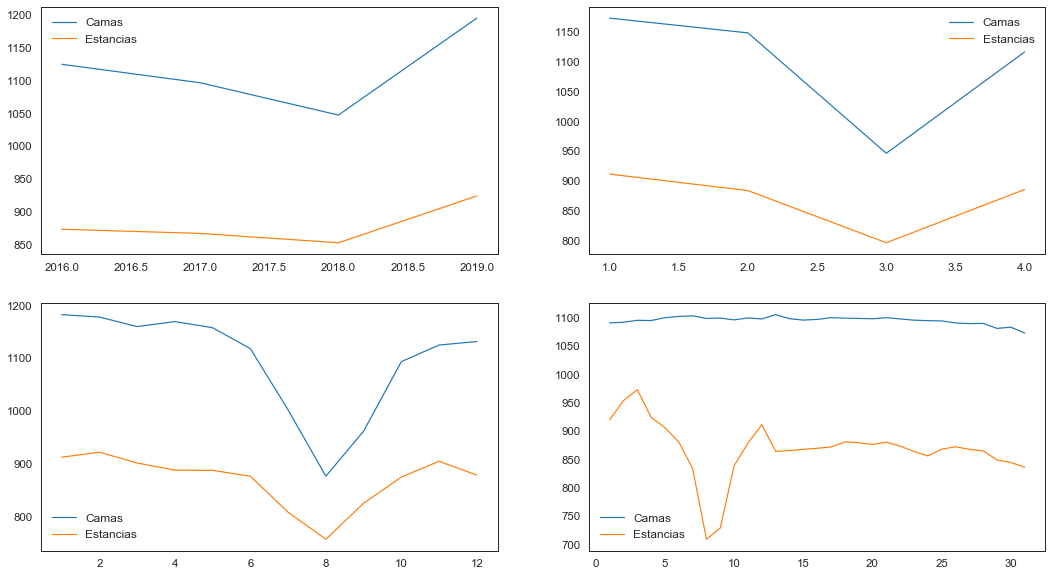

In [489]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
df_all2.groupby('year').Camas.agg('mean').plot()
df_all.groupby('year').Estancias.agg('mean').plot()
plt.xlabel('',fontsize=19)

plt.legend(fontsize=12,loc='upper ', frameon=False)

plt.subplot(2,2,2)
df_all2.groupby('quarter').Camas.agg('mean').plot()
df_all.groupby('quarter').Estancias.agg('mean').plot()

plt.xlabel('',fontsize=19)

plt.legend(fontsize=12,loc='upper lft', frameon=False)
plt.subplot(2,2,3)
df_all2.groupby('month').Camas.agg('mean').plot()
df_all.groupby('month').Estancias.agg('mean').plot()

plt.xlabel('',fontsize=19)

plt.legend(fontsize=12,loc='upper ', frameon=False)
plt.subplot(2,2,4)
df_all2.groupby('day').Camas.agg('mean').plot()
df_all.groupby('day').Estancias.agg('mean').plot()

plt.xlabel('',fontsize=19)

plt.legend(fontsize=12, frameon=False)
;

### Ocupacion by Years

For 2006, we only have data for December, so remove 2006.

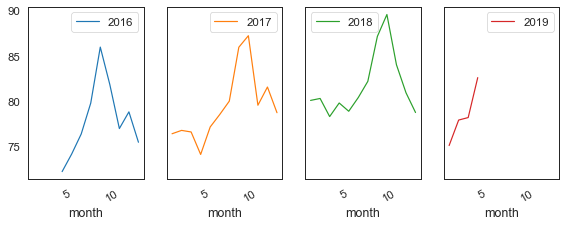

In [400]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Ocupacion", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

### Ocupacion consumption in Weekdays vs. Weekends

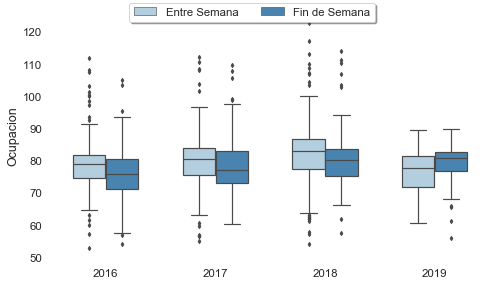

In [401]:
dic={0:'Fin de Semana',1:'Entre Semana'}
df['Day'] = df.weekday.map(dic)


a=plt.figure(figsize=(7,4)) 
plt1=sns.boxplot('year','Ocupacion',hue='Day',width=0.6,fliersize=3,
                    data=df,palette="Blues")                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('',fontsize=19)
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

The median Ocupacion in weekdays seems to be lower than the weekends prior to 2010.

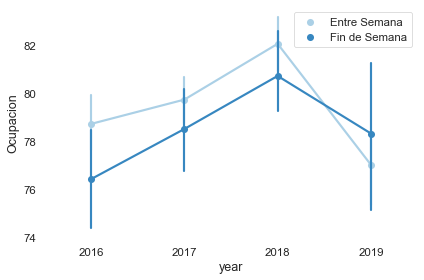

In [402]:
plt1=sns.factorplot('year','Ocupacion',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False,palette="Blues")                                                                                                                                                                                                                                                                                                                                             
#plt.title('Factor de Ocupacion entre semana y el fin de semana')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

Both weekdays and weekends have the similar trends over year.

In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

### Dickey-Fuller Test to Ceck Stationarity

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [506]:
#df2=df1.resample('D', how=np.mean)
df2 = df1.resample('D').agg(np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()
    
    plt.figure(figsize=(10,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

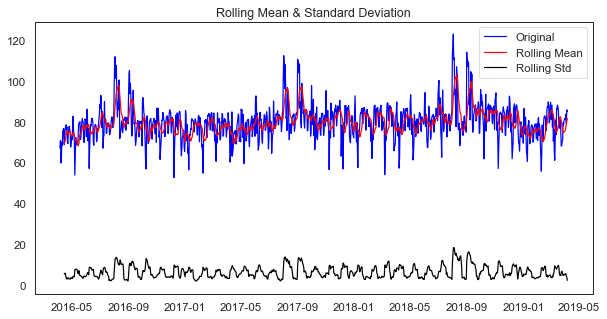

Test Statistic                  -5.7399
p-value                          0.0000
#Lags Used                      22.0000
Number of Observations Used   1073.0000
Critical Value (1%)             -3.4365
Critical Value (5%)             -2.8642
Critical Value (10%)            -2.5682
dtype: float64


In [507]:
test_stationarity(df2.Ocupacion.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

## LSTM


Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [405]:
dataset = df.Ocupacion.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [406]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [407]:
# reshape into X=t and Y=t+1
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [408]:
X_train.shape

(865, 10)

In [409]:
Y_train.shape

(865,)

In [410]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model Architecture

In [411]:
X_train.shape

(865, 1, 10)

In [412]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu',return_sequences=True))
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=90, batch_size=50, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 865 samples, validate on 209 samples
Epoch 1/90
865/865 [==============================] - 3s 3ms/step - loss: 0.0687 - val_loss: 0.0232
Epoch 2/90
865/865 [==============================] - 0s 358us/step - loss: 0.0191 - val_loss: 0.0132
Epoch 3/90
865/865 [==============================] - 0s 322us/step - loss: 0.0134 - val_loss: 0.0116
Epoch 4/90
865/865 [==============================] - 0s 325us/step - loss: 0.0136 - val_loss: 0.0110
Epoch 5/90
865/865 [==============================] - 0s 328us/step - loss: 0.0129 - val_loss: 0.0107
Epoch 6/90
865/865 [==============================] - 0s 331us/step - loss: 0.0126 - val_loss: 0.0104
Epoch 7/90
865/865 [==============================] - 0s 324us/step - loss: 0.0125 - val_loss: 0.0101
Epoch 8/90
865/865 [==============================] - 0s 324us/step - loss: 0.0118 - val_loss: 0.0099
Epoch 9/90
865/865 [==============================] - 0s 326us/step - loss: 0.0112 - val_loss: 0.0097
Epoch 10/90
865/865 [=================

In [413]:
data = df['Ocupacion']
data_Ocupacion =  df[['Ocupacion']]

In [414]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 4.83012528089196
Train Root Mean Squared Error: 6.644283978314137
Test Mean Absolute Error: 4.87481684677634
Test Root Mean Squared Error: 6.38840019715418


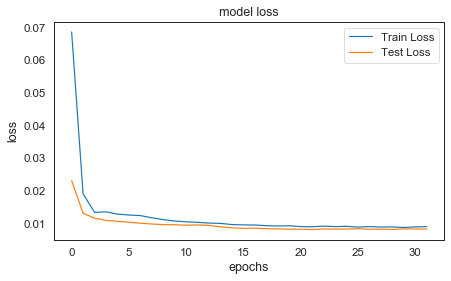

In [415]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

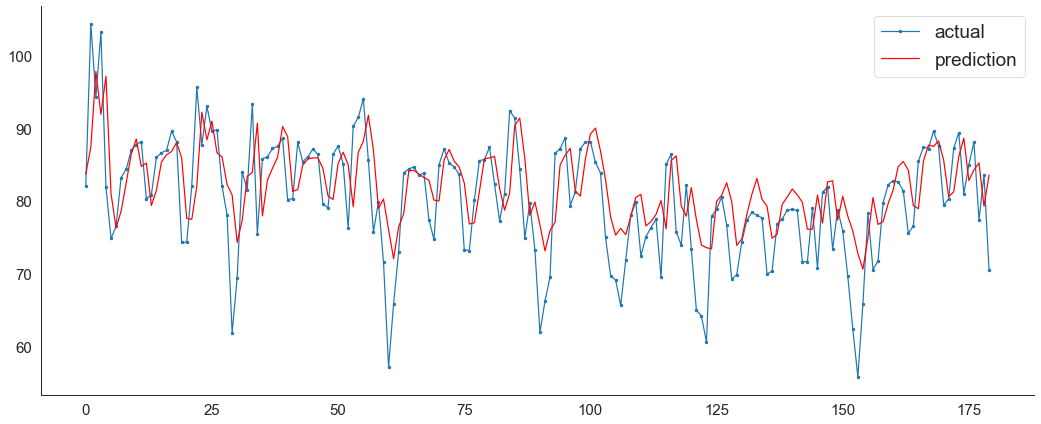

In [416]:
aa=[x for x in range(180)]
plt.figure(figsize=(15,6))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tick_params(labelsize=15) #remove ticks
plt.tight_layout()
b = sns.despine(top=True)


plt.subplots_adjust(left=0.07)
#plt.ylabel('Ocupacion', size=19,fontsize=17)
#plt.xlabel('Time step', size=19,fontsize=17)
plt.legend(fontsize=19)
plt.show();